<h1>Exercise 4: The Multi-Step Calculator</h1> 

### The Challenge
Complexity often comes from chaining simple decisions together.

**Goal:** Build a calculator that performs **two sequential steps**, but each step involves a decision.

**Requirements:**
1. **Step 1**: Check `operator1` (+ or -) and apply it to `num1` & `num2` -> Save to `finalNum`.
2. **Step 2**: Check `operator2` (+ or -) and apply it to `num3` & `num4` -> Save to `finalNum2`.
3. **Flow**: Step 1 must finish before Step 2 begins.

### The Solution
We need two routers! One for the first decision, and one for the second.

In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

### Step 1: The Massive State
We need to hold all inputs and intermediate results.

In [2]:
class AgentState(TypedDict):
    num1: int
    operator1: str
    num2: int
    num3: int
    num4: int
    operator2: str
    finalNum: int  # Result of Step 1
    finalNum2: int # Result of Step 2

### Step 2: The Logic Nodes (Round 1)
These handle the first calculation.

In [3]:
def addNode(state: AgentState) -> AgentState:
    """Node: Add num1 + num2"""
    print("--- Step 1: Adding ---")
    state["finalNum"] = state["num1"] + state["num2"]
    return state

def subNode(state: AgentState) -> AgentState:
    """Node: Subtract num1 - num2"""
    print("--- Step 1: Subtracting ---")
    state["finalNum"] = state["num1"] - state["num2"]
    return state

In [4]:
def routerFunc1(state: AgentState) -> str:
    """Router 1: Decides what loop to take for Step 1"""
    if(state["operator1"] == "+"):
        return "addEdge"
    elif(state["operator1"] == "-"):
        return "subEdge"

### Step 3: The Logic Nodes (Round 2)
These handle the second calculation.

In [5]:
def addNode2(state: AgentState) -> AgentState:
    """Node: Add num3 + num4"""
    print("--- Step 2: Adding ---")
    state["finalNum2"] = state["num3"] + state["num4"]
    return state

def subNode2(state: AgentState) -> AgentState:
    """Node: Subtract num3 - num4"""
    print("--- Step 2: Subtracting ---")
    state["finalNum2"] = state["num3"] - state["num4"]
    return state

In [6]:
def routerFunc2(state: AgentState) -> str:
    """Router 2: Decides what loop to take for Step 2"""
    if(state["operator2"] == "+"):
        return "addEdge2"
    elif(state["operator2"] == "-"):
        return "subEdge2"

### Step 4: The Complex Graph
This is where it gets interesting.
1. `Start` -> `Router1`.
2. `Router1` -> `Add` OR `Sub`.
3. CRITICAL: BOTH `Add` and `Sub` point to `Router2`. This ensures that no matter what happened in Step 1, we always proceed to Step 2.

In [7]:
graph = StateGraph(AgentState)

# 1. Add all nodes
graph.add_node("adder", addNode)
graph.add_node("sub", subNode)
graph.add_node("adder2", addNode2)
graph.add_node("sub2", subNode2)

# We use these 'passthrough' nodes to make the graph easier to route
graph.add_node("router1", lambda x: x) 
graph.add_node("router2", lambda x: x) 

# 2. Start -> Router 1
graph.add_edge(START, "router1")

# 3. Router 1 Logic
graph.add_conditional_edges(
    "router1", 
    routerFunc1, 
    {
        "addEdge": "adder",
        "subEdge": "sub"
    }
)

# 4. Connect Step 1 to Router 2
# Both paths from Step 1 converge here
graph.add_edge("adder", "router2")
graph.add_edge("sub", "router2")

# 5. Router 2 Logic
graph.add_conditional_edges(
    "router2", 
    routerFunc2,
    {
        "addEdge2": "adder2",
        "subEdge2": "sub2"
    }
)

# 6. Finish
graph.add_edge("adder2", END)
graph.add_edge("sub2", END)

app = graph.compile()

### Step 5: Visualization
You should see two diamond shapes (decisions) connected in a line.

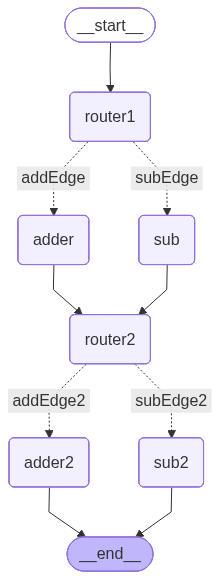

In [8]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

### Step 6: The Grand Test
Let's do: `10 - 5` AND `7 + 2`.

In [9]:
result = app.invoke({
    "num1": 10, "operator1": "-", "num2": 5, 
    "num3": 7, "num4": 2, "operator2": "+", 
    "finalNum": 0, "finalNum2": 0
})

print(f"Step 1 Result: {result['finalNum']}")
print(f"Step 2 Result: {result['finalNum2']}")

--- Step 1: Subtracting ---
--- Step 2: Adding ---
Step 1 Result: 5
Step 2 Result: 9
